# Arrival Time Prediction - Pointwise
This notebook is the second on the work on GP regression for arrival time prediction. In it, we will train a GP to predict arrival time solely on the GPs coordinates. That is, we will not consider trajectories, but instead view all data produced by different trajectories for one route as if it comes from the same gaussian process. Let's begin!

In [1]:
import gpflow
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import pandas as pd
import time
from datetime import datetime
from sklearn.preprocessing import StandardScaler
import scipy.stats as stats 
import math

sns.set(style="darkgrid")
np.random.seed(1)
df = pd.read_pickle('data.pkl')

We'll train on a bunch of trajectories, then evaluate on some other.

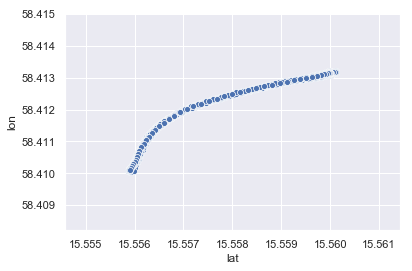

In [2]:
n_train = 30
seg_n = 3
training = df[df.traj < n_train]
seg = training[training.seg == seg_n]
sns.scatterplot(x="lat", y="lon", data=seg)

We need to choose some priors for our hyperparameters. I've cheated on these and tried out some values that finally worked. This is because the priors i reasoned about and thought was fine seem to have caused the covariance matrix to fail to fulfill the criterion of being Hermitian and positive definite, which is required for cholesky decomposition used when computing the posterior.

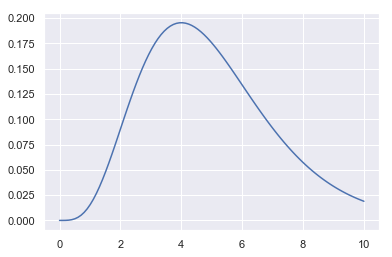

In [14]:
xmin = 0
xmax = 10
xx = np.linspace(xmin, xmax, 100)[:,None]
y = stats.gamma.pdf(xx, a=5, scale=1)
sns.lineplot(x = xx[:,0], y = y[:,0])

In [16]:
#k = gpflow.kernels.RBF(2, lengthscales=0.05, variance=0.01, ARD=True)
rbf = gpflow.kernels.RBF(2, ARD=True)
X_unnorm = np.vstack((seg['lat'], seg['lon'])).T
scaler = StandardScaler().fit(X_unnorm)
X = scaler.transform(X_unnorm)
Y = np.array(seg['t']).reshape(seg.shape[0],1) #np.array(seg['t']).reshape(seg.shape[0],1) # seg['t'].max() # Temporal progress
m = gpflow.models.GPR(X, Y, rbf)
m.clear()
m.kern.lengthscales.prior = gpflow.priors.Gamma(5, 0.008)
m.kern.variance.prior = gpflow.priors.Gamma(1., 1.)
m.likelihood.variance.prior = gpflow.priors.Gamma(5., 10)

m.compile()
opt = gpflow.train.ScipyOptimizer()
opt.minimize(m)
m.as_pandas_table()

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 5899.097318
  Number of iterations: 28
  Number of functions evaluations: 31


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 5899.097318
  Number of iterations: 28
  Number of functions evaluations: 31


,class,prior,transform,trainable,shape,fixed_shape,value
GPR/kern/lengthscales,Parameter,"Ga(5.0,0.008)",+ve,True,"(2,)",True,"[0.19134605298952853, 0.1504050045683223]"
GPR/kern/variance,Parameter,"Ga(1.0,1.0)",+ve,True,(),True,61.36926152889903
GPR/likelihood/variance,Parameter,"Ga(5.0,10.0)",+ve,True,(),True,40.71131222773088


Plotting the true time left vs the actual time left show that the model struggle in the beginning of the segment

C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


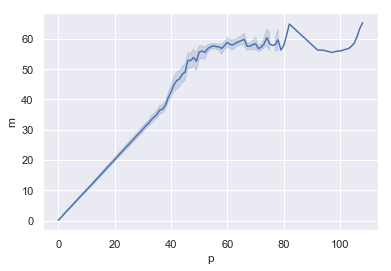

In [17]:
mean, var = m.predict_y(X)
progress_df = pd.DataFrame(np.hstack([X,Y,mean]), columns=list('xypm'))
sns.lineplot(x ='p', y='m', data=progress_df)

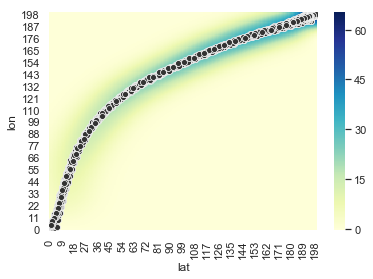

In [18]:
# Plot of posterior mean
padding = 0 # Padding does not work when overlaying the data in scatterplot
norm_latmax = X[:,0].max() + padding
norm_latmin = X[:,0].min() - padding 
norm_longmax = X[:,1].min() - padding
norm_longmin = X[:,1].max() + padding
d = 200
xlist = np.linspace(norm_latmin, norm_latmax, d)
ylist = np.linspace(norm_longmin, norm_longmax, d)
xx, yy = np.meshgrid(xlist, ylist)
grid = np.array([np.reshape(xx,(-1,)).T,np.reshape(yy,(-1,))]).T
mean, var = m.predict_y(grid)
#m2 , v = m.predict_y(X)
lat_unnorm = seg['lat']
lon_unnorm = seg['lon']
lat_grid = ((lat_unnorm-lat_unnorm.min())/(lat_unnorm.max() - lat_unnorm.min()))*d
lon_grid = ((lon_unnorm-lon_unnorm.min())/(lon_unnorm.max() - lon_unnorm.min()))*d
df_grid = pd.DataFrame({'lat':lat_grid, 'lon': lon_grid})

hm_grid = mean.reshape(d,d)[::-1] # Flip in y direction
hm = sns.heatmap(hm_grid,cmap="YlGnBu")
hm.invert_yaxis()
sns.scatterplot(x='lat', y='lon', data=df_grid, color=".2", axes=hm)


That's our model! Let's test it on other trajectories

In [22]:
n_test = 10
test = df[(df.traj > n_train) & (df.traj <= n_train + n_test)]
X_unnorm = np.vstack((test['lat'], test['lon'])).T 
scaler = StandardScaler().fit(X_unnorm)
X = scaler.transform(X_unnorm)
Y = np.array(test['t']).reshape(test.shape[0],1)
Ys, var = m.predict_y(X)
np.mean(abs(Y-Ys))

array([[  0.],
       [157.],
       [109.],
       ...,
       [  2.],
       [  1.],
       [  0.]])

Very sad performance indeed. Looking at the data, the total travel time of different trajectories have mean 177s and standard deviation 47s (There are also very many empty trajectories, which is a bit weird). I think that the poor result could be linked to this, but I havn't been able to figure it out yet. It is also quite hard to deduce things, since the data becomes unsynchronised from t=1 and forward.

Number of empties 64
mean 177.40650180605724
std 47.32104173987475


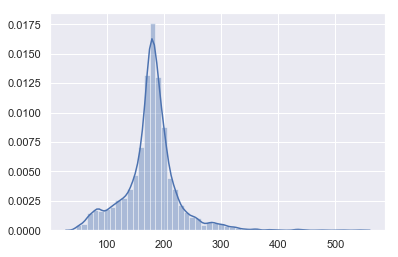

In [44]:
ts = []
empties = []
for i in range(1, int(df.traj.max())):
    traj = df[df.traj == i]
    if len(traj) == 0:
        empties.append(i)
        continue
        
    t0 = traj.iloc[0].t
    if t0 == 0.0:
        ts.append(traj.iloc[1].t)
    else:
        ts.append(t0)
        
print("Number of empties", len(empties))
sns.distplot(ts)
print("mean", np.mean(ts))
print("std", np.std(ts))

In conclusion, this approach will not do. Modelling arrival times based solely on spatial position will probably never get good results. The reason for this is that if the model is trained on several trajectories, the prediction will be some pointwise average of those, where the exact value depends on the GPs kernel lengthscale and variance. That would mean that if the model was trained on data with both very heavy and very light traffic, the prediction would average that and believe that the traffic is always average, which while fine as uninformed guess is not good enough for accurate predictions.

To solve this problem we need to try and predict on a trajectory level, and not data point level. By training on entire trajectories and predicting using a mixture of those it should be possible to learn a model that makes predictions by comparing the similarities of the new trajectory and the ones in the training set, and based of those similarities make a weighted prediction. This concept requires synchonising the trajectories, which is done in the notebook `Arrival Time Predictin - Synchronisation`